In [1]:
# structure de données
import pandas as pd
import numpy as np

# Traitement de texte
from bs4 import BeautifulSoup
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer

# graphique
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# A. Importation des données

##### Fichiers csv provenant de l'extraction SQL de StackOverFlow. Seule une partie de la table "posts" a été récupérée

In [3]:
train = pd.read_csv("train.csv", sep=',', header=0)
test = pd.read_csv('test.csv', sep=',', header=0)

In [4]:
print("La table d'entrainement a {} posts et {} variables".format(
    train.shape[0], train.shape[1]))
train.head()

La table d'entrainement a 204432 posts et 9 variables


,Id,Score,ViewCount,Body,Title,Tags,AnswerCount,CommentCount,FavoriteCount
0,26477388,23,5693.0,<p>In SBT is the use of <em>aggregate</em> fol...,Is the use of 'aggregate' following by 'depend...,<build><sbt>,1.0,0,9.0
1,20580028,22,37747.0,"<p>I'm designed a <a href=""http://en.wikipedia...","Flowchart ""for each"" loop loop without variabl...",<flowchart>,5.0,1,2.0
2,15096219,22,21065.0,<p>I'm trying to register a new log</p>\n\n<pr...,How to create a folder (if not present) with L...,<ruby-on-rails><ruby><logging>,3.0,0,4.0
3,16853747,87,11309.0,<pre><code>class Test{\n public static void...,Static block in Java not executed,<java><static><access-modifiers>,5.0,2,26.0
4,2036744,27,21402.0,<p>I have to write some code in ML and it is m...,ML IDE and Compiler for Windows or Linux or Mac,<ide><compiler-construction><programming-langu...,6.0,0,17.0


##### Pourquoi pas gardé acceptedanswerid?? creation date?

##### filtrage sur post type id? ==> 1 seulement donc pas besoin de parent id ?

In [5]:
print("La table de test a {} posts et {} variables".format(
    test.shape[0], test.shape[1]))
test.head()

La table de test a 51109 posts et 9 variables


,Id,Score,ViewCount,Body,Title,Tags,AnswerCount,CommentCount,FavoriteCount
0,14964108,26,32507.0,<p>I'm currently trying to build a little test...,Alternative to PhantomJS for Testing,<javascript><testing><phantomjs>,4.0,1,7.0
1,7439273,26,18913.0,<p>I am handling touches for a couple of my UI...,"UIScrollView prevents touchesBegan, touchesMov...",<iphone><uiscrollview><touch><viewcontroller><...,5.0,1,8.0
2,29382728,26,14626.0,<p>I just read somewhere that having an interf...,Constant Interface Anti-Pattern Clarification,<java>,4.0,2,3.0
3,13883404,26,68725.0,<p>I'm interested in a PowerShell script that ...,Custom RoboCopy Progress Bar in PowerShell,<powershell>,7.0,2,20.0
4,27241881,26,20075.0,<p>I am trying to rename the class name in swi...,How to rename the class name in swift?,<ios><swift>,7.0,6,3.0


# B. Nettoyage des tables

## B.1. Variables de prédiction

### B.1.a. Extraction des labels à partir de tags

In [6]:
def extract_label(serie):
    return [', '.join(map(str, re.findall(r'\<(.*?)\>', x))) for x in serie]

In [7]:
# Multilabels?

### B.1.b. Suppression labels avec faible occurence

In [8]:
# merge labels
def get_general_label(label):
    if 'python' in label:
        return 'python'
    elif 'c++' in label:
        return 'c++'
    elif 'asp.net' in label:
        return 'asp.net'
    elif 'ruby-on-rails' in label:
        return 'ruby-on-rails'
    elif 'visual-studio' in label:
        return 'visual-studio'
    elif 'javascript' in label:
        return 'javascript'
    elif 'java' in label:
        return 'java'
    elif 'angular' in label:
        return 'angular'
    elif 'android_studio' in label:
        return 'android-studio'
    elif 'android' in label:
        return 'android'
    else:
        return label

In [9]:
def keep_frequent_label(dataset, label_column, threshold=0.001):
    df = dataset.copy()
    # récupération de tous les labels --> count vectorizer?
    list_labels = [get_general_label(
        j) for i in df[label_column] for j in i.split(", ")]
    # On conserve les labels dont la fréquence d'apparition est > threshold
    freq = pd.Series(list_labels).value_counts(normalize=True)
    print(freq)
    clean_list_labels = freq[freq > threshold]
    print('{} tags sur {} ont été conservés'.format(
        clean_list_labels.shape[0], freq.shape[0]))

    # application au dataset
    df[label_column] = [', '.join(map(str, [get_general_label(y) for y in x.split(
        ", ") if y in clean_list_labels.index])) for x in df[label_column]]
    # suppression doublons apres fusion
    df[label_column] = [', '.join(set(i.split(", ")))
                        for i in df[label_column]]

    # suppression des posts sans label du dataset
    clean_df = df[df[label_column] != '']
    print('La table est passée de {} posts à {} posts après suppression des posts sans tags'.format(
        df.shape[0], clean_df.shape[0]))

    return clean_df

In [11]:
# Extraction des labels
train['Labels'] = extract_label(train['Tags'])
test['Labels'] = extract_label(test['Tags'])

# Filtrage sur tags les plus fréquents
clean_train = keep_frequent_label(train, 'Labels', 0.001)
clean_test = keep_frequent_label(test, 'Labels', 0.001)

android              0.041486
java                 0.034003
python               0.033461
javascript           0.028939
c#                   0.027308
                       ...   
qwerty               0.000002
dcraw                0.000002
downtime             0.000002
azure-redis-cache    0.000002
                     0.000002
Length: 18772, dtype: float64
111 tags sur 18772 ont été conservés
La table est passée de 204432 posts à 179247 posts après suppression des posts sans tags
android                 0.040796
java                    0.033586
python                  0.033547
javascript              0.029384
c#                      0.026428
                          ...   
google-account          0.000006
money-format            0.000006
avmutablecomposition    0.000006
django-annotate         0.000006
ora-00923               0.000006
Length: 10992, dtype: float64
114 tags sur 10992 ont été conservés
La table est passée de 51109 posts à 44700 posts après suppression des posts sans ta

In [12]:
clean_train.head()

,Id,Score,ViewCount,Body,Title,Tags,AnswerCount,CommentCount,FavoriteCount,Labels
2,15096219,22,21065.0,<p>I'm trying to register a new log</p>\n\n<pr...,How to create a folder (if not present) with L...,<ruby-on-rails><ruby><logging>,3.0,0,4.0,"ruby, ruby-on-rails, logging"
3,16853747,87,11309.0,<pre><code>class Test{\n public static void...,Static block in Java not executed,<java><static><access-modifiers>,5.0,2,26.0,java
6,4178605,47,271394.0,"<p>In Red Hat,</p>\n\n<pre><code>cd /var/lib/t...",Tomcat view catalina.out log file,<linux><tomcat>,12.0,4,14.0,linux
7,8057499,22,5274.0,"<p>In Google Chrome, the CSS hover state isn't...",Chrome won't apply css hover style when left m...,<css><google-chrome><webkit>,6.0,5,5.0,"css, google-chrome"
8,493433,23,41119.0,<p>Originally I though I'll just take a screen...,Best way to create Default.png image for iPhon...,<iphone><cocoa-touch>,9.0,0,10.0,"cocoa-touch, iphone"


## B.2. Variables d'entrée texte

In [13]:
clean_train.loc[3, 'Body']

'<pre><code>class Test{\n    public static void main(String arg[]){    \n        System.out.println("**MAIN METHOD");\n        System.out.println(Mno.VAL);//SOP(9090);\n        System.out.println(Mno.VAL+100);//SOP(9190);\n    }\n\n}\n\nclass Mno{\n    final static int VAL=9090;\n    static{\n        System.out.println("**STATIC BLOCK OF Mno\\t:"+VAL);\n    }\n}\n</code></pre>\n\n<p>I know that a <code>static</code> block executed when class loaded. But in this case the instance variable inside class <code>Mno</code> is <code>final</code>, because of that the <code>static</code> block is not executing. </p>\n\n<p>Why is that so? And if I would remove the <code>final</code>, would it work fine? </p>\n\n<p>Which memory will be allocated first, the <code>static final</code> variable or the <code>static</code> block? </p>\n\n<p>If due to the <code>final</code> access modifier the class does not get loaded, then how can the variable get memory?</p>\n'

### B.2.a Suppression code

In [14]:
def del_code(serie):
    basic_regex = '[ \n\r\t]'
    clean_serie = [re.sub(basic_regex, " ", x) for x in serie]
    pattern = '<pre><code>(.*?\s)</code></pre>'  # avec ou sans pre??
    return [re.sub(pattern, '', x) for x in clean_serie]

### B.2.b. Suppression balises HTML

In [15]:
def del_html(serie):
    return [BeautifulSoup(x, 'html.parser').get_text() for x in serie]

### B.2.c. Concaténation titre et body

In [16]:
def get_full_text(dataset, text1, text2):
    return [str(x) + ' ' + y for x, y in zip(dataset[text1], dataset[text2])]

In [17]:
clean_train['Clean_body'] = del_code(clean_train['Body'])
clean_train['Clean_body'] = del_html(clean_train['Clean_body'])
clean_train['Text'] = get_full_text(clean_train, 'Title', 'Clean_body')

clean_test['Clean_body'] = del_code(clean_test['Body'])
clean_test['Clean_body'] = del_html(clean_test['Clean_body'])
clean_test['Text'] = get_full_text(clean_test, 'Title', 'Clean_body')

In [18]:
clean_train.loc[3, 'Text']

'Static block in Java not executed  I know that a static block executed when class loaded. But in this case the instance variable inside class Mno is final, because of that the static block is not executing.  Why is that so? And if I would remove the final, would it work fine?  Which memory will be allocated first, the static final variable or the static block?  If due to the final access modifier the class does not get loaded, then how can the variable get memory? '

### B.2.d. Tokenisation / Lemmatisation / Stop words

In [19]:
wnLemma = nltk.stem.WordNetLemmatizer()

In [20]:
class LemmaTokenizer:
    def __init__(self):
        self.wnl = wnLemma

    def __call__(self, doc):
        return [self.wnl.lemmatize(t.lower()) for t in nltk.word_tokenize(doc) if t not in stopwords and t.isalpha()]

In [21]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": nltk.corpus.wordnet.ADJ,
                "N": nltk.corpus.wordnet.NOUN,
                "V": nltk.corpus.wordnet.VERB,
                "R": nltk.corpus.wordnet.ADV}

    return tag_dict.get(tag, nltk.corpus.wordnet.NOUN)

In [22]:
def tokenize(serie_text, stop_words):
    # Tokenization
    # Suppression des stopwords et caractères numériques
    # lemmatisation

    # passage en minuscule et suppression des caractèresn numériques
    tokens_serie = [[t.lower() for t in nltk.word_tokenize(
        text) if t.isalpha()] for text in serie_text]
    tokens_serie = [[wnLemma.lemmatize(
        t) for t in tokens if t not in stop_words] for tokens in tokens_serie]
    return tokens_serie

In [23]:
def text_from_tokens(serie_tokens):
    serie_text = [' '.join([y for y in x])for x in serie_tokens]
    return serie_text

In [24]:
# Récupération des stop words anglais
try:
    stopwords = nltk.corpus.stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
    stopwords = nltk.corpus.stopwords.words('english')

lemma_stopwords = [wnLemma.lemmatize(y, get_wordnet_pos(y)) for y in stopwords]
stopwords = set(stopwords + lemma_stopwords)

In [25]:
list(stopwords)[:20]

['about',
 'hasn',
 're',
 "that'll",
 'o',
 'before',
 'be',
 "didn't",
 'while',
 'yourself',
 "should've",
 'having',
 'yourselves',
 'your',
 'was',
 'of',
 'hadn',
 'them',
 'himself',
 'how']

In [26]:
clean_train['Tokens'] = tokenize(clean_train['Text'], stopwords)
clean_train['Text'] = text_from_tokens(clean_train['Tokens'])

clean_test['Tokens'] = tokenize(clean_test['Text'], stopwords)
clean_test['Text'] = text_from_tokens(clean_test['Tokens'])

In [27]:
clean_train.head()

,Id,Score,ViewCount,Body,Title,Tags,AnswerCount,CommentCount,FavoriteCount,Labels,Clean_body,Text,Tokens
2,15096219,22,21065.0,<p>I'm trying to register a new log</p>\n\n<pr...,How to create a folder (if not present) with L...,<ruby-on-rails><ruby><logging>,3.0,0,4.0,"ruby, ruby-on-rails, logging",I'm trying to register a new log but when I tr...,create folder present trying register new log ...,"[create, folder, present, trying, register, ne..."
3,16853747,87,11309.0,<pre><code>class Test{\n public static void...,Static block in Java not executed,<java><static><access-modifiers>,5.0,2,26.0,java,I know that a static block executed when clas...,static block java executed know static block e...,"[static, block, java, executed, know, static, ..."
6,4178605,47,271394.0,"<p>In Red Hat,</p>\n\n<pre><code>cd /var/lib/t...",Tomcat view catalina.out log file,<linux><tomcat>,12.0,4,14.0,linux,"In Red Hat, I can see the log in the console. ...",tomcat view log file red hat see log console u...,"[tomcat, view, log, file, red, hat, see, log, ..."
7,8057499,22,5274.0,"<p>In Google Chrome, the CSS hover state isn't...",Chrome won't apply css hover style when left m...,<css><google-chrome><webkit>,6.0,5,5.0,"css, google-chrome","In Google Chrome, the CSS hover state isn't be...",chrome wo apply cs hover style left mouse butt...,"[chrome, wo, apply, cs, hover, style, left, mo..."
8,493433,23,41119.0,<p>Originally I though I'll just take a screen...,Best way to create Default.png image for iPhon...,<iphone><cocoa-touch>,9.0,0,10.0,"cocoa-touch, iphone",Originally I though I'll just take a screensho...,best way create image iphone app originally th...,"[best, way, create, image, iphone, app, origin..."


In [28]:
final_train = clean_train.drop(columns=['Body', 'Title', 'Tags', 'Clean_body'])
final_test = clean_test.drop(columns=['Body', 'Title', 'Tags', 'Clean_body'])

In [29]:
final_train.head()

,Id,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,Labels,Text,Tokens
2,15096219,22,21065.0,3.0,0,4.0,"ruby, ruby-on-rails, logging",create folder present trying register new log ...,"[create, folder, present, trying, register, ne..."
3,16853747,87,11309.0,5.0,2,26.0,java,static block java executed know static block e...,"[static, block, java, executed, know, static, ..."
6,4178605,47,271394.0,12.0,4,14.0,linux,tomcat view log file red hat see log console u...,"[tomcat, view, log, file, red, hat, see, log, ..."
7,8057499,22,5274.0,6.0,5,5.0,"css, google-chrome",chrome wo apply cs hover style left mouse butt...,"[chrome, wo, apply, cs, hover, style, left, mo..."
8,493433,23,41119.0,9.0,0,10.0,"cocoa-touch, iphone",best way create image iphone app originally th...,"[best, way, create, image, iphone, app, origin..."


# C. Exploration

In [30]:
def hist_plot(df, var, nb_bins=50):
    df[var].hist(density=True, bins=nb_bins)
    plt.xlabel(var)
    plt.ylabel('Densité')
    plt.title('Distribution de {} \npour un échantillon de {} individus'.format(
        var, df.shape[0]))

## C.1. Variables numériques

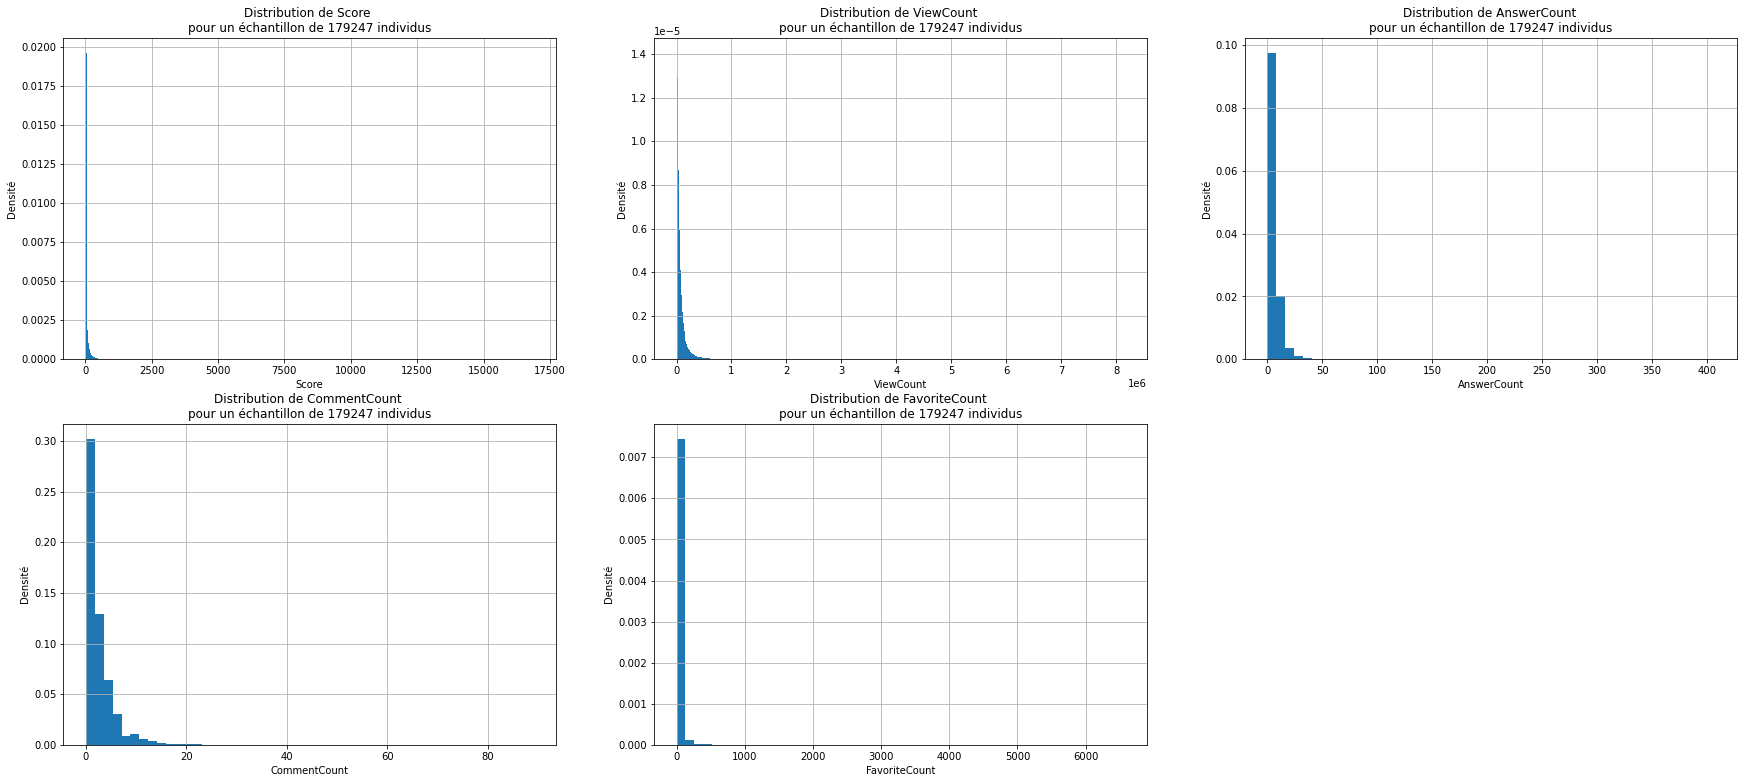

In [31]:
# Score des questions
plt.figure(figsize=(30, 13))
plt.subplot(231)
hist_plot(final_train, 'Score', 500)
plt.subplot(232)
hist_plot(final_train, 'ViewCount', 500)
plt.subplot(233)
hist_plot(final_train, 'AnswerCount')
plt.subplot(234)
hist_plot(final_train, 'CommentCount')
plt.subplot(235)
hist_plot(final_train, 'FavoriteCount')

## C.2. Variables qualitatives

### C.2.a. Labels

In [32]:
all_clean_labels = [j for i in final_train['Labels']
                    for j in i.split(", ") if j != '']

In [33]:
pd.Series(all_clean_labels).value_counts()

java                 18590
javascript           17541
python               17218
c#                   16861
android              14758
                     ...  
sql-server-2008        634
lambda                 633
spring-mvc             628
testing                622
language-agnostic      619
Length: 111, dtype: int64

In [34]:
freq = pd.Series(all_clean_labels).value_counts(normalize=True)

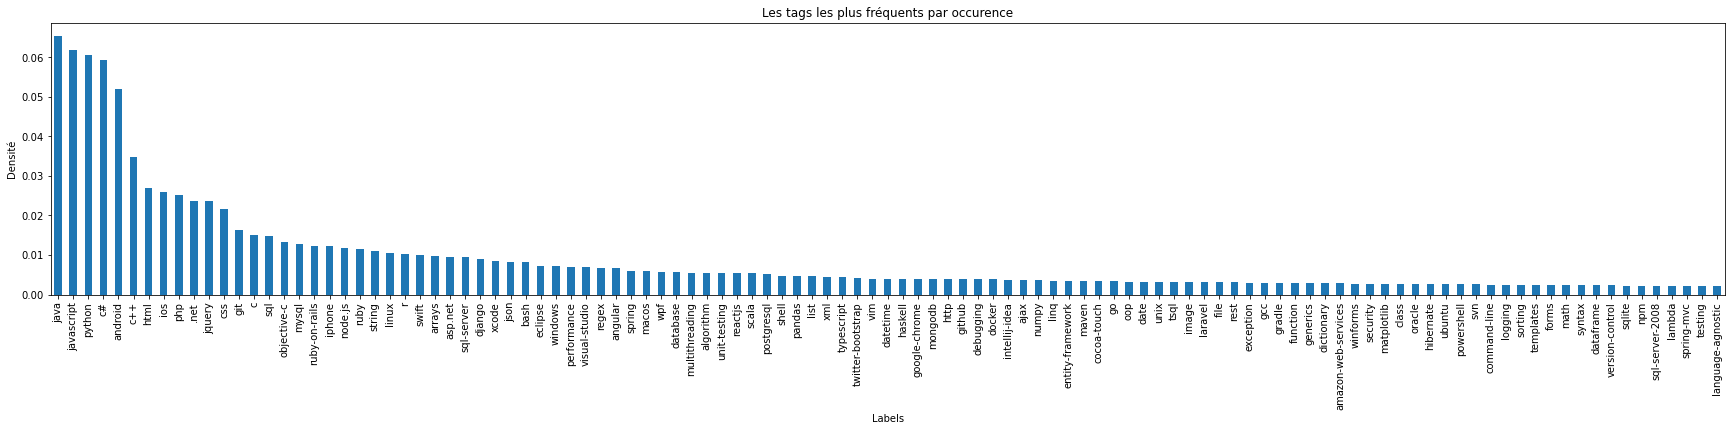

In [35]:
plt.figure(figsize=(30, 5))
plt.xlabel('Labels')
plt.ylabel('Densité')
freq.plot(kind='bar', title='Les tags les plus fréquents par occurence');

In [36]:
freq.shape

(111,)

### C.2.b. Mots

In [37]:
all_words = [j for i in final_train['Tokens'] for j in i if j != '']
freq_words = pd.Series(all_words).value_counts()

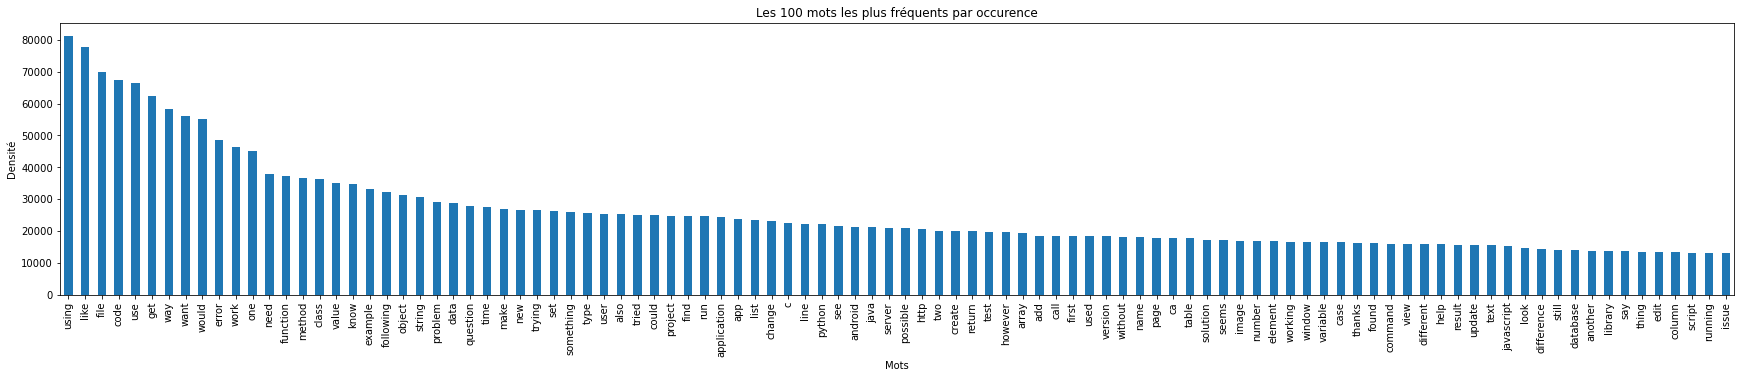

In [38]:
plt.figure(figsize=(30, 5))
plt.xlabel('Mots')
plt.ylabel('Densité')
plt.xticks(rotation=50)
freq_words[:100].plot(
    kind='bar', title='Les 100 mots les plus fréquents par occurence');

In [39]:
freq_words.shape

(95953,)

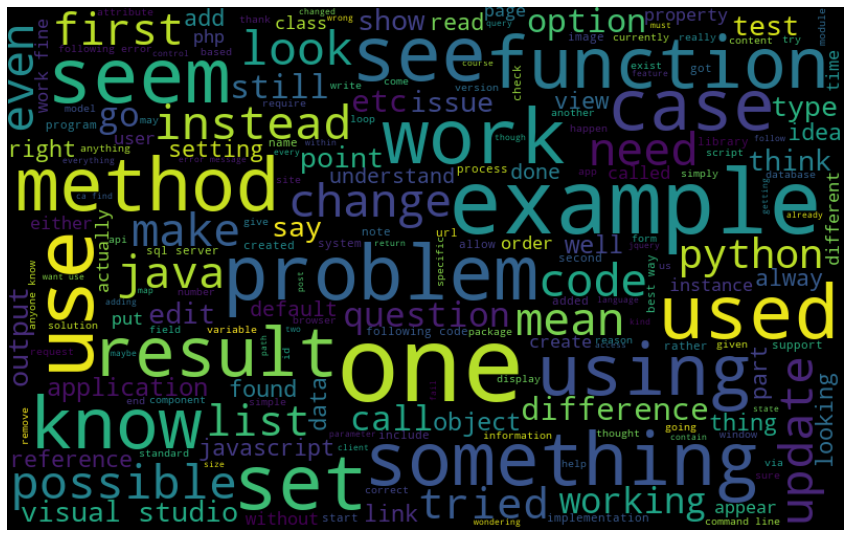

In [47]:
# Word cloud sur l'ensemble des posts
text = ' '.join([x for x in final_train['Text']])
wordcloud = WordCloud(width=800, height=500, random_state=0,
                      max_font_size=100).generate(text)
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

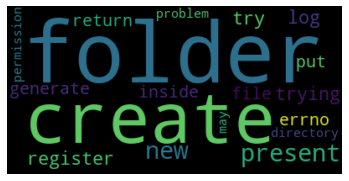

In [48]:
# Word cloud d'un post
wordcloud = WordCloud().generate(final_train.loc[2, 'Text'])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

In [42]:
# Faire une analyse multivariée

In [43]:
# Réduction dimensionnelle
# StopWords?

# D. Export des données

In [50]:
final_train.head()

,Id,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,Labels,Text,Tokens
2,15096219,22,21065.0,3.0,0,4.0,"ruby, ruby-on-rails, logging",create folder present trying register new log ...,"[create, folder, present, trying, register, ne..."
3,16853747,87,11309.0,5.0,2,26.0,java,static block java executed know static block e...,"[static, block, java, executed, know, static, ..."
6,4178605,47,271394.0,12.0,4,14.0,linux,tomcat view log file red hat see log console u...,"[tomcat, view, log, file, red, hat, see, log, ..."
7,8057499,22,5274.0,6.0,5,5.0,"css, google-chrome",chrome wo apply cs hover style left mouse butt...,"[chrome, wo, apply, cs, hover, style, left, mo..."
8,493433,23,41119.0,9.0,0,10.0,"cocoa-touch, iphone",best way create image iphone app originally th...,"[best, way, create, image, iphone, app, origin..."


In [49]:
final_train.to_csv('clean_train.csv', index=False)
final_test.to_csv('clean_test.csv', index=False)

In [46]:
# nombre de tags?(1000/300) nombre de mots?(20361) nombres de posts?(10000/44000)
# 600mots/posts